In [1]:
from iterativeBase import *
from scipy.optimize import brute
from scipy.optimize import minimize
import math
import itertools

In [2]:
class IterativeBacktest(IterativeBase):
    ''' Class for iterative (event-driven) backtesting of trading strategies.

    Methods
    =======
    go_long:
        executes trades to take a long position

    go_short:
        executes trades to take a short position
    
    setup:
        prepares data for testing

    test_sma_strategy:
        tests a simple moving average strategy

    test_boll_strategy:
        tests a bollinger bands strategy

    test_macd_strategy:
        tests an macd strategy

    test_stoch_strategy:
        tests an stochastic oscillator strategy

    test_mr_rsi_strategy:
        tests a mean reversion strategy using RSI values

    calculate_rsi:
        calculates the rsi for each row in the price column
    
    calculate_average_gain_loss:
        calculates the average gain or loss in a window

    combine_strategies_unanimous:
        combines two strategies together based on whether they agree or not

    combine_strategies_majority:
        combines two strategies together based on the majority vote

    data_clean_up:
        cleans up data after strategy has completed, calculating strategy and returns performance

    optimise_parameters:
        optimises performance of a strategy given
    '''

    def go_long(self, bar, units = None, amount = None):
        ''' Executes trades to take a long position

        Parameters
        ==========
        bar: int
            bar to get values for

        units: int
            number of units to sell

        amount: int
            ammount to sell
        '''
        if self.position == -1:
            self.buy_instrument(bar, units = -self.units) # if short position, go neutral first
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance
            self.buy_instrument(bar, amount = amount) # go long

    def go_short(self, bar, units = None, amount = None):
        ''' Executes trades to take a short position

        Parameters
        ==========
        bar: int
            bar to get values for

        units: int
            number of units to sell

        amount: int
            ammount to sell
        '''
        if self.position == 1:
            self.sell_instrument(bar, units = self.units) # if long position, go neutral first
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance
            self.sell_instrument(bar, amount = amount) # go short

    def setup(self, stm, lines, delete_data, *args):
        ''' Prepares data for testing
        
        Parameters
        ==========
        stm: str
            statement to print

        lines: int
            number of lines to print

        delete data: bool
            whether to clear data frame
        '''
        stm = stm.format(self.symbol, *args)
        self.lines = lines
        lines = "-" * self.lines

        print(lines)
        print(stm)
        print(lines)

        # reset 
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_balance  # reset initial capital
        self.report[:] = [lines, stm, lines]
        if delete_data:
            self.get_data() # reset dataset
        return

    def test_sma_strategy(self, SMA_S, SMA_L, delete_data=True):
        ''' Tests a simple moving average strategy

        Parameters
        ==========
        SMA_S: int
            value to used to calculate short moving average

        SMA_L: int
            value to used to calculate long moving average

        delete_data: bool
            whether to reset data or not
        '''
   
        stm = "Testing SMA strategy | {} | SMA_S = {} & SMA_L = {}"
        self.setup(stm, 75, delete_data, SMA_S, SMA_L)
        
        # prepare data
        self.data["SMA_S"] = self.data["price"].rolling(SMA_S).mean()
        self.data["SMA_L"] = self.data["price"].rolling(SMA_L).mean()
        self.data.dropna(inplace = True)

        self.data["nav"] = 0
        self.data["sma_position"] = 0
        # sma crossover strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.data["SMA_S"].iloc[bar] > self.data["SMA_L"].iloc[bar]: # signal to go long
                if self.position in [0, -1]:
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position
                    
            elif self.data["SMA_S"].iloc[bar] < self.data["SMA_L"].iloc[bar]: # signal to go short
                if self.position in [0, 1]:
                    self.go_short(bar, amount = "all") # go short with full amount
                    self.position = -1 # short position

            self.data.loc[self.data.index[bar], "sma_position"] = self.position
            self.data.loc[self.data.index[bar], "nav"] = self.current_balance + self.units * self.data["price"].iloc[bar]
            
        self.close_pos(bar+1) # close position at the last bar
        self.data_clean_up(bar+1)
        return self.current_balance 

                
    def test_boll_strategy(self, SMA, dev, delete_data=True):
        ''' Tests a bollinger bands strategy

        Parameters
        ==========
        SMA: int
            value to used to calculate moving average

        dev: int
            number of standard deviations to use in bands

        delete_data: bool
            whether to reset data or not
        '''

        # nice printout
        stm = "Testing Bollinger Bands Strategy | {} | SMA = {} & dev = {}"
        self.setup(stm, 75, delete_data, SMA, dev)
        
        # prepare data
        self.data["SMA"] = self.data["price"].rolling(SMA).mean()
        self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(SMA).std() * dev
        self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(SMA).std() * dev
        self.data.dropna(inplace = True) 
        
        self.data["nav"] = 0
        self.data["boll_position"] = 0
        # Bollinger strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.position == 0: # when neutral
                if self.data["price"].iloc[bar] < self.data["Lower"].iloc[bar]: # signal to go long
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position
                elif self.data["price"].iloc[bar] > self.data["Upper"].iloc[bar]: # signal to go Short
                    self.go_short(bar, amount = "all") # go short with full amount
                    self.position = -1 # short position
            elif self.position == 1: # when long
                if self.data["price"].iloc[bar] > self.data["SMA"].iloc[bar]:
                    if self.data["price"].iloc[bar] > self.data["Upper"].iloc[bar]: # signal to go short
                        self.go_short(bar, amount = "all") # go short with full amount
                        self.position = -1 # short position
                    else:
                        self.sell_instrument(bar, units = self.units) # go neutral
                        self.position = 0
            elif self.position == -1: # when short
                if self.data["price"].iloc[bar] < self.data["SMA"].iloc[bar]:
                    if self.data["price"].iloc[bar] < self.data["Lower"].iloc[bar]: # signal to go long
                        self.go_long(bar, amount = "all") # go long with full amount
                        self.position = 1 # long position
                    else:
                        self.buy_instrument(bar, units = -self.units) # go neutral
                        self.position = 0   
            self.data.loc[self.data.index[bar], "boll_position"] = self.position
            self.data.loc[self.data.index[bar], "nav"] = self.current_balance + self.units * self.data["price"].iloc[bar]

        self.close_pos(bar+1) # close position at the last bar
        self.data_clean_up(bar+1)
        return self.current_balance 

    def test_macd_strategy(self, EMA_S, EMA_L, signal, delete_data=True):
        ''' Tests an macd strategy

        Parameters
        ==========
        EMA_S: int
            value to used to calculate short exponential moving average

        EMA_L: int
            value to used to calculate long exponential moving average

        signal: int
            value used to calculate signal line based on macd line

        delete_data: bool
            whether to reset data or not
        '''
        
        # nice printout
        stm = "Testing MACD strategy | {} | EMA_S = {}, EMA_L = {}, & Signal = {}"
        self.setup(stm, 75, delete_data, EMA_S, EMA_L, signal)
        
        # prepare data
        ema_s = self.data["price"].ewm(span=EMA_S, min_periods=EMA_S, adjust=False).mean()
        ema_l = self.data["price"].ewm(span=EMA_L, min_periods=EMA_L, adjust=False).mean()
        self.data["macd"] = ema_s - ema_l

        self.data["signal"] = self.data["macd"].ewm(span=signal, min_periods=signal, adjust=False).mean()
        self.data.dropna(inplace = True)

        self.data["nav"] = 0
        self.data["macd_position"] = 0
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.data["signal"].iloc[bar] > self.data["macd"].iloc[bar]: # signal to go long
                if self.position in [0,-1]:
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position

            elif self.data["signal"].iloc[bar] < self.data["macd"].iloc[bar]: # signal to go short
                if self.position in [0,1]:
                    self.go_short(bar, amount = "all") # go short with full amount
                    self.position = -1 # short position
            self.data.loc[self.data.index[bar], "macd_position"] = self.position
            self.data.loc[self.data.index[bar], "nav"] = self.current_balance + self.units * self.data["price"].iloc[bar]

        self.close_pos(bar+1) # close position at the last bar
        self.data_clean_up(bar+1)
        return self.current_balance 

    def test_stoch_strategy(self, k_lookback, d_lookback, delete_data=True):
        ''' Tests an stochastic oscillator strategy

        Parameters
        ==========
        k_lookback: int
            window used to find lowest and highest value

        d_lookback: int
            windows used to calculate moving average of k% line

        delete_data: bool
            whether to reset data or not
        '''

        # nice printout
        stm = "Testing Stochastic Oscillator strategy | {} | k_lookback = {} & d_lookback = {}"
        self.setup(stm, 88, delete_data, k_lookback, d_lookback)

        df = self.api.get_history(instrument=self.symbol, start=self.start, end=self.end, granularity=self.granularity, price="M")
        df = df[["h", "l"]]
        self.data = self.data.join(df)

        lowest_low = self.data.l.rolling(k_lookback).min()
        highest_high = self.data.h.rolling(k_lookback).max()
        self.data["%k"] = ((self.data["price"] - lowest_low) / (highest_high - lowest_low)) * 100
        self.data["%d"] = self.data["%k"].rolling(d_lookback).mean()
        self.data.dropna(inplace = True)

        self.data["nav"] = 0
        self.data["stoch_position"] = 0
        for bar in range(len(self.data)-1):
            if self.data["%k"].iloc[bar] < 20 and self.data["%d"].iloc[bar] < 20 and self.data["%k"].iloc[bar] < self.data["%d"].iloc[bar]:
                if self.position != 1: 
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position
                else: # go neutral
                    self.sell_instrument(bar, units = self.units) # go neutral
                    self.position = 0
            elif self.data["%k"].iloc[bar] > 80 and self.data["%d"].iloc[bar] > 80 and self.data["%k"].iloc[bar] > self.data["%d"].iloc[bar]:
                if self.position != -1: 
                    self.go_short(bar, amount = "all") # go long with full amount
                    self.position = -1  # long position
                else: 
                    self.buy_instrument(bar, units = -self.units) # go neutral
                    self.position = 0    
            self.data.loc[self.data.index[bar], "stoch_position"] = self.position
            self.data.loc[self.data.index[bar], "nav"] = self.current_balance + self.units * self.data["price"].iloc[bar]

        self.close_pos(bar + 1)  # close position at the last bar
        self.data_clean_up(bar + 1)

        return self.current_balance

    def test_mr_rsi_strategy(self, rsi_lookback, rsi_threshold_high, rsi_threshold_low, delete_data=True):
        ''' Tests a mean reversion strategy using RSI values

        Parameters
        ==========
        rsi_lookback: int
            windows to look back 

        rsi_threshold_high: int
            upper threshold for ri

        rsi_threshold_low: int
            lower threshold for ri
        
        delete_data: bool
            whether to reset data or not
        '''

        # nice printout
        stm = "Testing Mean Reversion with RSI strategy | {} | rsi_lookback = {}, rsi_threshold_high = {}, & rsi_threshold_low = {}"
        self.setup(stm, 125, delete_data, rsi_lookback, rsi_threshold_high, rsi_threshold_low)

        self.data["rsi"] = self.calculate_rsi(self.data["price"].values, rsi_lookback)
        self.data.dropna(inplace = True)

        self.data["nav"] = 0
        self.data["mr_rsi_position"] = 0
        for bar in range(len(self.data) - 1):
            rsi = self.data["rsi"].iloc[bar]

            if rsi > rsi_threshold_high and self.position != -1:  # RSI crosses above overbought threshold
                self.go_short(bar, amount="all")
                self.position = -1
            elif rsi < rsi_threshold_low and self.position != 1:  # RSI crosses below oversold threshold
                self.go_long(bar, amount="all")
                self.position = 1

            self.data.loc[self.data.index[bar], "mr_rsi_position"] = self.position
            self.data.loc[self.data.index[bar], "nav"] = self.data.loc[self.data.index[bar], "nav"] = self.current_balance + self.units * self.data["price"].iloc[bar]


        self.close_pos(bar + 1)  # Close position at the last bar
        self.data_clean_up(bar + 1)
        return self.current_balance

    def calculate_rsi(self, prices, lookback):
        ''' Calculates the rsi for each row in the price column

        Parameters
        ==========
        prices: Series
            series of price values in the dataframe

        lookback: int
            window to look back by
        '''
        gain = np.where(prices[1:] > prices[:-1], prices[1:] - prices[:-1], 0)
        loss = np.where(prices[1:] < prices[:-1], prices[:-1] - prices[1:], 0)
        avg_gain = self.calculate_average_gain_loss(gain, lookback)
        avg_loss = self.calculate_average_gain_loss(loss, lookback)
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return np.insert(rsi, 0, np.nan)

    def calculate_average_gain_loss(self, data, window):
        ''' Calculates the average gain or loss in a window

        Parameters
        ==========
        data: Series
            series of gains or loses

        window: int
            window to look back by
        '''
        return pd.Series(data).rolling(window=window, min_periods=1).mean().values

    def combine_strategies_unanimous(self, func1, func2, **kwargs):
        ''' Combines two strategies together based on whether they agree or not

        Parameters
        ==========
        func1: Function
            first strategy to use

        func2: Function
            second strategy to use
        '''
        args1 = {k: v for k, v in kwargs.items() if k in func1.__code__.co_varnames}
        args2 = {k: v for k, v in kwargs.items() if k in func2.__code__.co_varnames}
        
        func1(**args1, delete_data=False)
        func2(**args2, delete_data=False)

        position_columns = self.data.filter(like="position")
        position_1_name, position_2_name = position_columns.columns[0], position_columns.columns[1]

        stm = "Testing Combination strategy | {} ".format(self.symbol)
        lines = "-" * 88
        print (lines)
        print (stm)
        print (lines)

        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_balance  # reset initial capital
        self.report[:] = [lines, stm, lines]
        self.data.dropna(inplace = True)
        
        self.data["nav"] = 0
        for bar in range(len(self.data) - 1):
        
            position_1 = self.data[position_1_name].iloc[bar]
            position_2 = self.data[position_2_name].iloc[bar]

            if position_1 == position_2 and self.position != position_1:
                if position_1 == 1:
                    self.go_long(bar, amount="all")
                    self.position = 1
                elif position_1 == -1:
                    self.go_short(bar, amount="all")
                    self.position = -1
                elif position_1 == 0:
                    if self.position == 1:
                        self.sell_instrument(bar, units = self.units)
                    elif self.position == -1:
                        self.buy_instrument(bar, units = -self.units)
            self.data.loc[self.data.index[bar], "nav"] = self.data.loc[self.data.index[bar], "nav"] = self.current_balance + self.units * self.data["price"].iloc[bar]


        self.close_pos(bar + 1)  # Close position at the last bar
        self.data_clean_up(bar + 1)
        return self.current_balance
    
    def combine_strategies_majority(self, func1, func2, **kwargs):
        ''' Combines two strategies together based on the majority vote

        Parameters
        ==========
        func1: Function
            first strategy to use

        func2: Function
            second strategy to use
        '''
        args1 = {k: v for k, v in kwargs.items() if k in func1.__code__.co_varnames}
        args2 = {k: v for k, v in kwargs.items() if k in func2.__code__.co_varnames}
        
        func1(**args1, delete_data=False)
        func2(**args2, delete_data=False)

        position_columns = self.data.filter(like="position")
        position_1_name, position_2_name = position_columns.columns[0], position_columns.columns[1]

        stm = "Testing Combination strategy | {} ".format(self.symbol)
        lines = "-" * 88
        print (lines)
        print (stm)
        print (lines)

        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_balance  # reset initial capital
        self.report[:] = [lines, stm, lines]
        self.data.dropna(inplace = True)
        
        self.data["nav"] = 0
        for bar in range(len(self.data) - 1):
        
            position_1 = self.data[position_1_name].iloc[bar]
            position_2 = self.data[position_2_name].iloc[bar]
            position_maj = (position_1 + position_2) // 2
            
            if position_maj != self.position:
                if position_maj == 1:
                    self.go_long(bar, amount="all")
                    self.position = 1
                elif position_maj == -1:
                    self.go_short(bar, amount="all")
                    self.position = -1
                elif position_maj == 0:
                    if self.position == 1:
                        self.sell_instrument(bar, units = self.units)
                    elif self.position == -1:
                        self.buy_instrument(bar, units = -self.units)
            self.data.loc[self.data.index[bar], "nav"] = self.data.loc[self.data.index[bar], "nav"] = self.current_balance + self.units * self.data["price"].iloc[bar]


        self.close_pos(bar + 1)  # Close position at the last bar
        self.data_clean_up(bar + 1)
        return self.current_balance
        

    def data_clean_up(self, bar):
        ''' Cleans up data after strategy has completed, calculating strategy and returns performance

        Parameters
        ==========
        bar: int
            bar to get values for
        '''
        self.data.loc[self.data.index[bar], "nav"] = self.current_balance 

        self.data["strategy"] = np.log(self.data.nav / self.data.nav.shift(1))
        self.data["creturns"] = self.data["returns"].cumsum().apply(np.exp)
        self.data["cstrategy"] = self.data["strategy"].cumsum().apply(np.exp)

    def optimise_parameters(self, func, *ranges, early_termination_threshold=None):
        ''' Optimises performance of a strategy given

        Parameters
        ==========
        func: Functions
            function to optimise
        
        *ranges: tuple
            ranges of values to test

        early_termination_threshold: int
            value to stop execution of function at if performance exceeds
        '''
        best_value = float('-inf') 
        best_combination = None

        def generate_combinations():
            for r in ranges:
                yield np.arange(r[0], r[1] + 1)

        for combo in itertools.product(*generate_combinations()):
            value = func(*combo)
            
            if early_termination_threshold is not None and value >= early_termination_threshold:
                return combo, value
            
            if value > best_value:
                best_value = value
                best_combination = combo

        return best_combination, best_value

In [3]:
test = IterativeBacktest("/Users/dugaldmacintyre/Desktop/Oanda_firststeps/oanda.cfg", "EUR_USD", "2010-01-01", "2020-12-31", "D", 100000, use_spread=True)

Connection to v20 REST server at https://api-fxpractice.oanda.com:443/v3/instruments/EUR_USD/candles failed|Attempt: 1
Connection to v20 REST server at https://api-fxpractice.oanda.com:443/v3/instruments/EUR_USD/candles failed|Attempt: 2
Connection to v20 REST server at https://api-fxpractice.oanda.com:443/v3/instruments/EUR_USD/candles failed|Attempt: 3
Connection to v20 REST server at https://api-fxpractice.oanda.com:443/v3/instruments/EUR_USD/candles failed|Attempt: 4
Connection to v20 REST server at https://api-fxpractice.oanda.com:443/v3/instruments/EUR_USD/candles failed|Attempt: 5
5 attempts reached. Please check your connection and try again


In [151]:
# test.combine_strategies_majority(test.test_mr_rsi_strategy, test.test_macd_strategy, rsi_lookback=14, rsi_threshold_high=70, rsi_threshold_low=30, EMA_S=12, EMA_L=26, signal=9)

test.test_sma_strategy(50, 200)

---------------------------------------------------------------------------
Testing SMA strategy | EUR_USD | SMA_S = 50 & SMA_L = 200
---------------------------------------------------------------------------
2020-12-30 | +++ CLOSING FINAL POSITION +++
2020-12-30 | closing position of 96639 for 1.22156
2020-12-30 | Current Balance: 118017.1
2020-12-30 | net performance (%) = 18.02
2020-12-30 | number of trades executed = 32
---------------------------------------------------------------------------


118017.0973100001

In [145]:
test.data

,price,spread,returns,rsi,nav,mr_rsi_position,strategy,creturns,cstrategy,macd,signal,macd_position
time,,,,,,,,,,,,
2010-02-05 22:00:00,1.367900,0.00100,0.000000,17.577737,99963.46100,1,NaN,1.000000,NaN,-0.014900,-0.012420,1
2010-02-06 22:00:00,1.366020,0.00036,-0.001375,14.544418,99826.07436,1,-0.001375,0.998626,0.998626,-0.015496,-0.013035,1
2010-02-07 22:00:00,1.364890,0.00020,-0.000828,14.439411,99743.49622,1,-0.000828,0.997800,0.997800,-0.015877,-0.013603,1
2010-02-08 22:00:00,1.379740,0.00020,0.010821,32.301741,100828.70452,1,0.010821,1.008656,1.008656,-0.014810,-0.013845,1
2010-02-09 22:00:00,1.373730,0.00018,-0.004365,31.805485,100389.50574,1,-0.004365,1.004262,1.004262,-0.014284,-0.013933,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23 22:00:00,1.218490,0.00042,-0.000062,57.582682,118705.16247,-1,0.000000,0.890774,1.187486,0.008022,0.008617,1
2020-12-27 22:00:00,1.221515,0.00019,0.002480,62.152818,118705.16247,-1,0.000000,0.892986,1.187486,0.007791,0.008451,1
2020-12-28 22:00:00,1.225020,0.00020,0.002865,65.781520,118705.16247,-1,0.000000,0.895548,1.187486,0.007800,0.008321,1


In [141]:
position_columns = test.data.filter(like="position")
position_columns[position_columns.columns[0]]

time
2010-02-05 22:00:00    1
2010-02-06 22:00:00    1
2010-02-07 22:00:00    1
2010-02-08 22:00:00    1
2010-02-09 22:00:00    1
                      ..
2020-12-23 22:00:00   -1
2020-12-27 22:00:00   -1
2020-12-28 22:00:00   -1
2020-12-29 22:00:00   -1
2020-12-30 22:00:00    0
Name: mr_rsi_position, Length: 3111, dtype: int64

In [136]:
test.test_mr_rsi_strategy(14, 70, 30)

------------------------------------------------------------------------------------------------------------------------------------------------------
Testing Mean Reversion with RSI strategy | EUR_USD | rsi_lookback = 14, rsi_threshold_high = 70, & rsi_threshold_low = 30
------------------------------------------------------------------------------------------------------------------------------------------------------
2020-12-30 | +++ CLOSING FINAL POSITION +++
2020-12-30 | closing position of -88163 for 1.22156
2020-12-30 | Current Balance: 101631.77
2020-12-30 | net performance (%) = 1.63
2020-12-30 | number of trades executed = 152
---------------------------------------------------------------------------


101631.77300000025

In [90]:
test.test_macd_strategy(12,26,9)

---------------------------------------------------------------------------
Testing MACD strategy | EUR_USD | EMA_S = 12, EMA_L = 26, & Signal = 9
---------------------------------------------------------------------------
2020-12-30 | +++ CLOSING FINAL POSITION +++
2020-12-30 | closing position of 92464 for 1.22156
2020-12-30 | Current Balance: 112918.69
2020-12-30 | net performance (%) = 12.92
2020-12-30 | number of trades executed = 518
---------------------------------------------------------------------------


112918.69373500034

In [91]:
test.test_stoch_strategy(12, 5)
# test.data
# test.plot_data(["%k", "%d"], ("x", "y"), title=None, start = None, end=None)
# test.optimise_parameters(test.test_stoch_strategy, (12,16), (1,5))

----------------------------------------------------------------------------------------
Testing Stochastic Oscillator strategy | EUR_USD | k_lookback = 12 & d_lookback = 5
----------------------------------------------------------------------------------------
2020-12-30 | +++ CLOSING FINAL POSITION +++
2020-12-30 | closing position of -100725 for 1.22156
2020-12-30 | Current Balance: 124015.29
2020-12-30 | net performance (%) = 24.02
2020-12-30 | number of trades executed = 598
---------------------------------------------------------------------------


124015.28586000077

In [92]:
test.data.stoch_position.value_counts()

 0    1331
 1    1026
-1     774
Name: stoch_position, dtype: int64

In [ ]:
def plot_dataset(cols, title, ticks, start = test.data.index[0], end=test.data.index[-1]):
    data = test.data[start:end].copy()
    cols = data[cols]
    
    GREY30 = "#4d4d4d"
    GREY40 = "#474747"
    GREY60 = "#999999"
    GREY91 = "#e8e8e8"
    GREY98 = "#fafafa"

    palette = plt.get_cmap('Paired')

    fig, ax = plt.subplots()

    for i, col in enumerate(cols):
        ax.plot(data.index, data[col], marker='', color=palette((i+1)%palette.N), linewidth=1, alpha=0.9)

    ax.set_title(title, loc='center', fontsize=12, weight='bold', color=GREY40)
    ax.set_xlabel(ticks[0], color=GREY40)
    ax.set_ylabel(ticks[1], color=GREY40)

    ax.spines["left"].set_color(GREY91)
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.spines["bottom"].set_color(GREY91)

    fig.patch.set_facecolor(GREY98)
    ax.set_facecolor(GREY98)


    time_delta = data.index[-1] - data.index[0]
        
    if time_delta > pd.Timedelta(days=365):
        date_range = pd.date_range(start=start, end=end, freq='6M')

    elif time_delta > pd.Timedelta(days=28):
        date_range = pd.date_range(start=start, end=end, freq='M')

    elif time_delta > pd.Timedelta(hours=24):
        date_range = pd.date_range(start=start, end=end, freq='D')

    else:
        date_range = pd.date_range(start=start, end=end, freq='H')

    # Plot vertical lines at each time unit change
    for v in date_range:
        ax.axvline(x=v, color=GREY60, linewidth=0.6, alpha=0.5)
    ax.grid(False)
    y_min, y_max = ax.get_ylim()
    y_min = 1 if y_min > 1 else y_min * 0.75
    y_max = math.ceil(y_max) * 0.75 if math.ceil(y_max) * 0.75 > y_max else math.ceil(y_max)
    ax.hlines(y=np.arange(y_min, y_max, step=0.1), xmin=data.index[0], xmax=data.index[-1], color=GREY60, lw=0.6)

    # ax.set_ylim(y_min, y_max*0.8)

    # Last value in y (where to point to)
    y_starts = [data[col][-1] for col in cols]

    # Last value in x (where to start the line)
    x_start = data.index[-1]
    x_end = x_start + pd.Timedelta(days=int(len(data)/8))
    names = cols.columns

    for i in range(0, len(names)):
        text = "    " + names[i]
        y = y_starts[i]
        ax.plot([x_start, x_end], [y, y], color=palette((i+1)%palette.N), alpha=0.5, ls="dashed", lw=0.6)
        
        ax.text(x_end, y, text, va="center")

    # Show the graph
    plt.tight_layout()
    plt.show()

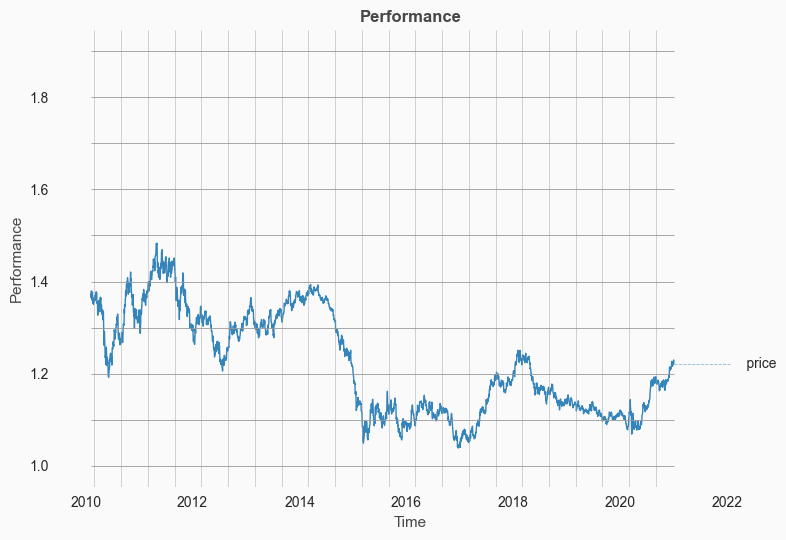

In [ ]:
test.plot_data(["price"], ("Time", "Performance"), "Performance", test.data.index[0], test.data.index[-1])

In [ ]:
palette = plt.get_cmap('Pastel1')

In [73]:
palette.N

9

In [77]:
(9+1)%palette.N

1

In [88]:
test.data.price

time
2010-02-03 22:00:00    1.372320
2010-02-04 22:00:00    1.367900
2010-02-05 22:00:00    1.367900
2010-02-06 22:00:00    1.366020
2010-02-07 22:00:00    1.364890
                         ...   
2020-12-23 22:00:00    1.218490
2020-12-27 22:00:00    1.221515
2020-12-28 22:00:00    1.225020
2020-12-29 22:00:00    1.229995
2020-12-30 22:00:00    1.221555
Name: price, Length: 3113, dtype: float64

In [72]:
test.data

,price,spread,returns,macd,signal,nav,strategy,creturns,cstrategy
time,,,,,,,,,
2010-02-03 22:00:00,1.372320,0.00020,-0.012348,-0.012968,-0.011121,99992.713700,NaN,0.987728,NaN
2010-02-04 22:00:00,1.367900,0.00100,-0.003226,-0.014172,-0.011731,99670.659240,-0.003226,0.984547,0.996779
2010-02-05 22:00:00,1.367900,0.00100,0.000000,-0.014955,-0.012376,99670.659240,0.000000,0.984547,0.996779
2010-02-06 22:00:00,1.366020,0.00036,-0.001375,-0.015547,-0.013010,99533.676800,-0.001375,0.983194,0.995409
2010-02-07 22:00:00,1.364890,0.00020,-0.000828,-0.015924,-0.013593,99451.341610,-0.000828,0.982381,0.994586
...,...,...,...,...,...,...,...,...,...
2020-12-23 22:00:00,1.218490,0.00042,-0.000062,0.008022,0.008617,112666.729335,-0.000062,0.877009,1.126749
2020-12-27 22:00:00,1.221515,0.00019,0.002480,0.007791,0.008451,112946.432935,0.002479,0.879186,1.129547
2020-12-28 22:00:00,1.225020,0.00020,0.002865,0.007800,0.008321,113270.519255,0.002865,0.881709,1.132788


In [102]:
def combine_strategies(func1, func2, **kwargs):
    args1 = {k: v for k, v in kwargs.items() if k in func1.__code__.co_varnames}
    args2 = {k: v for k, v in kwargs.items() if k in func2.__code__.co_varnames}
    
    func1(**args1)
    func2(**args2)
    return 


Combined Result: 35


In [114]:
(1 + 1) // 2

1

In [119]:
0 // 2

0

In [120]:
position_maj = (1 + 1) // 2


1
-1
